In [ ]:
!pip install datasets
!pip install transformers[torch]

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd
import os

In [ ]:
dataset_path = os.path.join("datasets", "top4_preparado.csv")

news_df = pd.read_csv(dataset_path)

train_df = news_df[news_df.split=='train']
eval_df = news_df[news_df.split=='val']
test_df = news_df[news_df.split=='test']

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.class_encode_column('category')
eval_dataset = eval_dataset.class_encode_column('category')
test_dataset = test_dataset.class_encode_column('category')

dataset_dict = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset,
    'test': test_dataset
})

print(dataset_dict)
print(dataset_dict['train'].features)

## Visualización de estadísticas del DataSet

Antes de seguir con el uso del dataset, vamos a visualizar algunas estadísticas del dataset.

In [ ]:
dataset_dict.set_format(type="pandas")
df = dataset_dict["train"][:]

def label_int2str(row):
    return dataset_dict["train"].features["category"].int2str(row)

df["label_name"] = df["category"].apply(label_int2str)
df.head()

La frecuencia de clases.

In [ ]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()
print(df["label_name"].value_counts(ascending=True))

Y algo muy relevante a la hora de usar modelos como DistilBERT que tienen una limitación en cuanto a context size. Para ello, vamos a visualizar cuál es la longitud máxima de nuestros textos.

In [ ]:
df["Words Per Title"] = df["title"].str.split().apply(len)
df.boxplot("Words Per Title", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

# Feature Extraction con DistilBERT

Una vez tenemos prepardo el dataset para ser usado dentro del ecosistema de HuggingFace, vamos a decidir qué encoder usar: en este caso vamos a usar DisiltBERT, una versión más pequeña de BERT.

El objetivo de este primer enfoque es obtener la representación que el modelo obtiene de cada una de las frases o ejemplos de entrenamiento que tenemos en nuestro corpus.

Una vez hemos obtenido esa representación, vamos a usarla como input features para un clasificador.

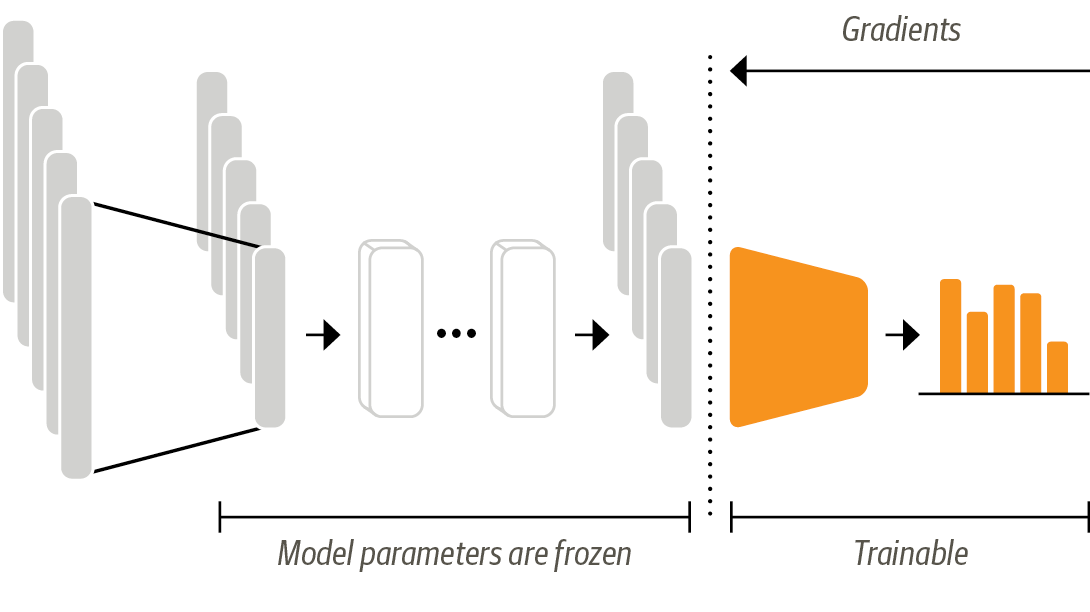

Lo primero que vamos a hacer es adaptar el dataset que está enforma de texto crudo y convertirlo en `token_ids` utilizando el tokenizer de DistilBERT.

In [ ]:
from transformers import AutoTokenizer

#Descargamos y creamos el tokenizer de distilbert.
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
#Método que llamará el mapper del dataset para ir transformando cada ejemplo de entrenamiento en la representación adecuada.
def tokenize(batch):
    return tokenizer(batch["title"], padding=True, truncation=True)

In [ ]:
#Antes lo habíamos pasado a pandas, volvemos a pasarlo a torch
dataset_dict.set_format(type="torch")

#Transformarmamos todo el dataset (los 3 splits) a token_ids.
news_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)


In [ ]:
print(news_encoded["train"].column_names)

Una vez tenemos todo el **dataset adaptado** para ser usado como **input** de un **DistilBERT**, vamos a **insertar en el modelo completo de DistilBERT** (esta vez no vamos a usar solo su tokenizer), para que nos devuelva la **representación** de cada una de las **frases** que usemos.

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel

#Cargamos el modelo completo de DistilBERT
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Antes de meter todo nuestro dataset en el modelo, vamos a ver qué pasa con un una frase de ejemplo.

Para ello, se utiliza el modelo para **realizar una inferencia** sobre los datos de entrada.

`with torch.no_grad()`: asegura que **no se calculen gradientes** durante esta operación, lo que es típico durante la inferencia (para **ahorrar memoria y tiempo de cálculo**).

`outputs = model(**inputs)` pasa los datos de entrada al modelo y obtiene las salidas

In [ ]:
text = "this is a test"
#Tokenizamos con el tokenizer de DistilBERT previamente cargado. La opción pt indica que tienen que ser tensores compatibles con pytorch.
inputs = tokenizer(text, return_tensors="pt")
#Aquí recordad que además de los input_ids también provee los attention_masks.
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(inputs.items())

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)
print(f"The shape of the outputs is {outputs.last_hidden_state.shape}")

Como podemos ver el shape es de `batch_size=1`, `number_tokens=6` y cada token tienen un `embedding_dimension=768`. Sin embargo, para la **clasificación** solo nos **interesa** el **hidden state** o representación **asociada** con el **token [CLS]** que es el primero de la secuencia.

In [ ]:
#Obtenemos el hidden state de [CLS]
outputs.last_hidden_state[:,0].size()


In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
news_encoded.set_format("torch", columns=["input_ids", "attention_mask", "category"])

#hide_output
news_hidden = news_encoded.map(extract_hidden_states, batched=True)

In [ ]:
news_hidden["train"].column_names


Ahora vamos a crear los sets ya codificados de manera que el feature extraction se ha llevado ya a cabo, es decir, por cada ejemplo tenemos un vector de 798 posiciones que representa el texto.

In [ ]:
import numpy as np

X_train = np.array(news_hidden["train"]["hidden_state"])
X_valid = np.array(news_hidden["eval"]["hidden_state"])
X_test = np.array(news_hidden["test"]["hidden_state"])
y_train = np.array(news_hidden["train"]["category"])
y_valid = np.array(news_hidden["eval"]["category"])
y_test = np.array(news_hidden["test"]["category"])
X_train.shape, X_valid.shape, X_test.shape


Ahora, estos **estados codificados** puede ser usados **features de entrada** de caualquier clasificador. En este caso vamos a usar un **LogisticRegression**.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)



In [ ]:
print(f"Accuracy for eval set is {lr_clf.score(X_valid, y_valid)}")
print(f"Accuracy for test set is {lr_clf.score(X_test, y_test)}")

# Fine-tuning DistilBERT

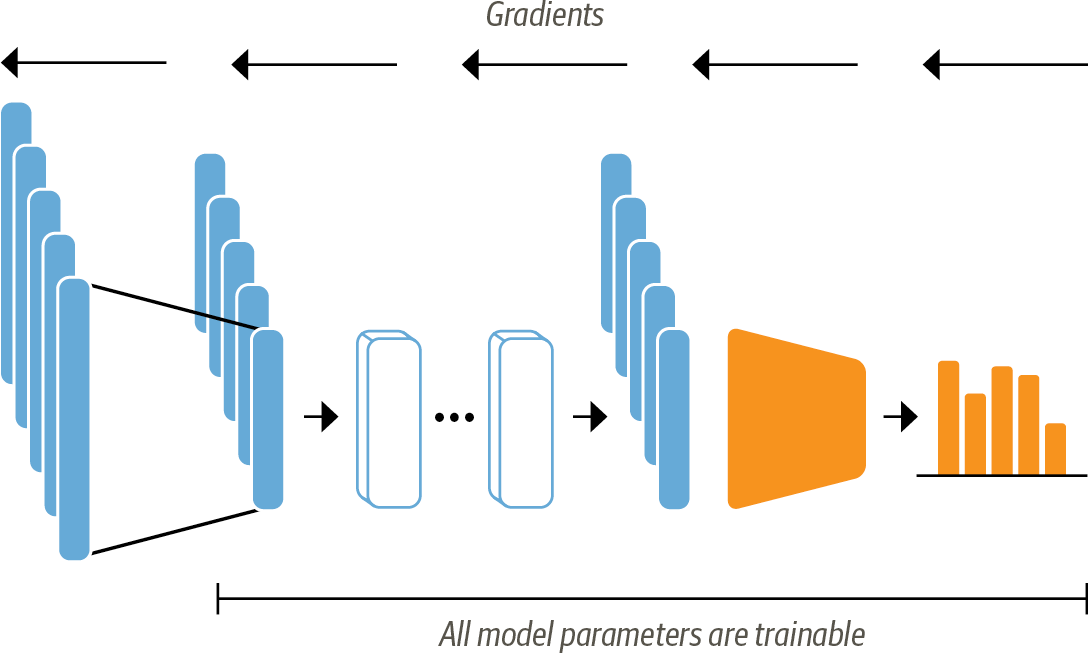

La clase `AutoModelForSequenceClassification` de transformers  tiene un head de clasificación después de las salidas del modelo preentrenado, la cual puede ser entrenada fácilmente con el modelo base. Solo necesitamos especificar cuántas clases debe predecir el modelo (4 en nuestro caso), ya que esto determina el número de salidas que tiene la cabeza de clasificación.

Saldrá un mensaje de warning indicando que los **pesos del head** no han sido inicializados o han sido inicializados de manera aleatoria.




In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(news_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer
#IMPORTANTE: cambiar el nombre de la columna vuestro label a label
news_encoded = news_encoded.rename_column("category", "label")
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=news_encoded["train"],
                  eval_dataset=news_encoded["eval"],
                  tokenizer=tokenizer)
trainer.train();


## ¿Qué es ese head que está dentro de los AutoModelForSequenceClassification?

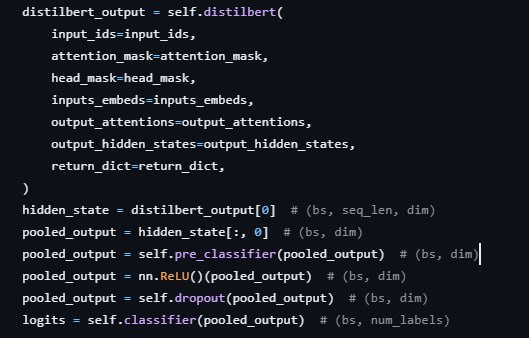

https://github.com/huggingface/transformers/blob/v4.35.2/src/transformers/models/distilbert/modeling_distilbert.py#L788